In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter

import qiskit.ignis.verification.tomography as tom
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Importing other packages
import pickle
import numpy as np

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from itertools import product

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
%qiskit_progress_bar
from qiskit.tools.parallel import parallel_map
parallel_map(np.sin, np.linspace(0,10,100));

In [4]:
from copy import deepcopy

In [20]:
#print('\n'.join([str(x) for x in provider.backends()]))
#print('---')
#print('\n'.join([str(x) for x in Aer.backends()]))
backend=provider.get_backend('ibmq_16_melbourne')
backend_sim=provider.get_backend('ibmq_qasm_simulator')
backend_sim_local=Aer.get_backend('qasm_simulator')
backend_sv=Aer.get_backend('statevector_simulator')

In [21]:
data_list=[0,1,2,3,4]
syn=[5]
flag=[6]

In [7]:
def StatePreparation(stabilizer=0):
    q = QuantumRegister(7)
    qc = QuantumCircuit(q)
    #prepare the 5-qubit graph state
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[2])
    qc.h(q[3])
    qc.h(q[4])
    qc.cz(q[0],q[1])
    qc.cz(q[2],q[3])
    qc.cz(q[1],q[2])
    qc.cz(q[3],q[4])
    qc.cz(q[0],q[4])
    #syndrome and flag extraction
    #stabilizer order: from left to right, Fig 2(a), SM of two extra qubits
    if(stabilizer==0):
        #first stabilizer 
        qc.h(q[5])
        qc.cx(q[5],q[0])
        qc.cx(q[5],q[6])
        qc.cz(q[1],q[5])
        qc.cx(q[5],q[6])
        qc.cz(q[4],q[5])
        qc.h(q[5])
    elif(stabilizer==1):
    #second stabilizer
        qc.h(q[5])
        qc.cz(q[0],q[5])
        qc.cx(q[5],q[6])
        qc.cx(q[5],q[1])
        qc.cx(q[5],q[6])
        qc.cz(q[2],q[5])
        qc.h(q[5])
    elif(stabilizer==2):
        #third stabilizer
        qc.h(q[5])
        qc.cx(q[5],q[3])
        qc.cx(q[5],q[6])
        qc.cz(q[2],q[5])
        qc.cx(q[5],q[6])
        qc.cz(q[4],q[5])
        qc.h(q[5])
    #measure syndrome and flag & do state tomography for the data qubits
    qc.barrier()
    #qc.measure(q[5],c[5])
    #qc.measure(q[6],c[6])
    return q, qc

In [8]:
q, qc=StatePreparation(0)
# ca = ClassicalRegister(1)
# qc.add_register(ca)
# qc.measure(q[0],ca[0])
qc.draw()
# qc.data

┌───┐         ┌───┐                      ░ 
q0_0: ┤ H ├─■─────■─┤ X ├──────────────────────░─
      ├───┤ │     │ └─┬─┘                      ░ 
q0_1: ┤ H ├─■──■──┼───┼────────■───────────────░─
      ├───┤    │  │   │        │               ░ 
q0_2: ┤ H ├─■──■──┼───┼────────┼───────────────░─
      ├───┤ │     │   │        │               ░ 
q0_3: ┤ H ├─■──■──┼───┼────────┼───────────────░─
      ├───┤    │  │   │        │               ░ 
q0_4: ┤ H ├────■──■───┼────────┼───────■───────░─
      ├───┤           │        │       │ ┌───┐ ░ 
q0_5: ┤ H ├───────────■────■───■───■───■─┤ H ├─░─
      └───┘              ┌─┴─┐   ┌─┴─┐   └───┘ ░ 
q0_6: ───────────────────┤ X ├───┤ X ├─────────░─
                         └───┘   └───┘         ░

To keep the consistence, the following blocks are mainly from `test state prep.ipynb`

In [9]:
import time

Based on https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/ignis/6a_state_tomography.ipynb?fbclid=IwAR1Pf1nH2CBPUWDdsa_xBiYs1kYDu8hwI9dVvr63z7ypmhy2UlR6QpMgJWc, 2-Qubit Conditional State Tomography

we should have projected the ideal final state to the final state, 'reduced(v,sf)' returns the projected states based on 'sf'. At the moment, for the simulation result, 'sf' can only be '00' and the func returns the first 32 elements of v.

In [10]:
def reduced(v, sf):
    s=int(sf[0])
    f=int(sf[1])
    out=s*2+f
    res=[]
    for i in range(v.shape[0]):
        if((i>>5)==out):#((i%4)==out):#
            res.append(v[i])
    res=np.array(res)
    res=res/np.sqrt(np.sum(np.power(np.abs(res),2)))
    return np.array(res)

## Main part

Circuit | Description 
---| ---
qc0 | As shown in [6], state prepartion + stabilizer, no measurement
qc1 | add measurements on syndrome and flag qubits
qctom | add measurements on syndrome and flag qubits, then do state tomography on data qubits, used for tomography by both simulation and experiment
qctom_no_anc | qctom without measurement, used for 'tom.stateTomographyFitter'


In [11]:
# backend.properties().qubit_property(0,name='prob_meas0_prep1')[0]
len(backend.properties()._qubits)

15

In [86]:
def msmtErrorMitFilter(backend, measured_qubit_list):
    # results is a list of the measurement statistics
    # backend is the backend from which we obtain measurement error rates
    # Generate a noise model for the 5 qubits
    # Generate the calibration circuits
    qr = QuantumRegister(len(measured_qubit_list))
    qubit_list = range(len(measured_qubit_list))
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
    noise_model = noise.NoiseModel()
    back_prop = backend.properties()
#     for qi in range(len(backend.properties()._qubits)):
    for qi in range(len(measured_qubit_list)):
        m0_p1 = back_prop.qubit_property(qi,name='prob_meas0_prep1')[0]
#         print(m0_p1)
        m1_p0 = back_prop.qubit_property(qi,name='prob_meas1_prep0')[0]
#         print(m1_p0)
        read_err = noise.errors.readout_error.ReadoutError([[1-m1_p0, m1_p0],[m0_p1,1-m0_p1]])
        noise_model.add_readout_error(read_err, [qi])
        
#     print('starting job execution')
#     print(len(meas_calibs))
    # Execute the calibration circuits
    job = execute(meas_calibs, backend=backend_sim_local, shots=1000, noise_model=noise_model)
    cal_results = job.result()
    
#     print('completed job execution')
    # Calculate the calibration matrix with the noise model
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
#     meas_fitter = meas_fitter.subset_fitter(qubit_sublist=measured_qubit_list)
#     print(meas_fitter.cal_matrix)
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    return meas_filter

In [84]:
def msmtErrorMitOnTom(results, meas_filter):
    #create pauli basis indices
    N = 5 # ------------change this number according to how many qubits you are doing state tomography on
    mitigated_results = deepcopy(results)

    for data_idx, _ in enumerate(results.results):
        old_counts = results.get_counts(data_idx)
        new_counts = {}
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            reg_bits = reg_bits[0]+reg_bits[1]
#             print(reg_bits)
            new_counts[hex(int(reg_bits,2))]=old_counts[reg_key]
                        
#         print(old_counts)
        new_counts1 = meas_filter.apply(new_counts)
#         print(new_counts1)
        
        mitigated_results.results[data_idx].data.counts = \
            mitigated_results.results[data_idx]. \
            data.counts.from_dict(new_counts)

#     mitigated_results = meas_filter.apply(raw_counts)
    return mitigated_results

In [85]:
 # DO NOT NEED TO RUN THIS. THIS WAS FOR TESTING
    
    N= 5
# res = [ele for ele in product(['X','Y','Z'], repeat = N)] 

print(results_sim0)

filt = msmtErrorMitFilter(backend, [0,1,2,3,4,5,6])
# print('hi')
# k = 1
# for data_idx, _ in enumerate(results_sim0.results):
#     if k==0 or k == 1:
#         print(results_sim0.get_counts(data_idx))
        
#         k = k+1
print(msmtErrorMitOnTom(results_sim0, filt))
# print(filt.apply(results_sim0))
    
# print(res)
# qctom[res[0]]

Result(backend_name='ibmq_qasm_simulator', backend_version='0.4.1', date=datetime.datetime(2020, 5, 6, 18, 28, 29, 225157), header=Obj(backend_name='ibmq_qasm_simulator', backend_version='0.1.547'), job_id='5eb301c4c165ac00126d6a66', metadata={'max_memory_mb': 121910, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.23868851000000002}, qobj_id='18f6df6c-383c-46bf-a944-a07cad7c7ec4', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x1=9, 0x10=6, 0x13=7, 0x15=2, 0x16=7, 0x19=5, 0x1a=9, 0x1c=4, 0x1f=5, 0x2=10, 0x4=6, 0x7=5, 0x8=3, 0xb=9, 0xd=6, 0xe=7)), header=Obj(clbit_labels=[['c8', 0], ['c8', 1], ['c8', 2], ['c8', 3], ['c8', 4], ['c9', 0], ['c9', 1]], creg_sizes=[['c8', 5], ['c9', 2]], memory_slots=7, n_qubits=7, name="('X', 'X', 'X', 'X', 'X')", qreg_sizes=[['q8', 7]], qubit_labels=[['q8', 0], ['q8', 1], ['q8', 2], ['q8', 3], ['q8', 4], ['q8', 5], ['q8', 6]]), meas_level=<MeasLevel.CLASSIFIED: 2>, metadata={'measure_sampling': True, 'method': 'stabilizer'

Result(backend_name='ibmq_qasm_simulator', backend_version='0.4.1', date=datetime.datetime(2020, 5, 6, 18, 28, 29, 225157), header=Obj(backend_name='ibmq_qasm_simulator', backend_version='0.1.547'), job_id='5eb301c4c165ac00126d6a66', metadata={'max_memory_mb': 121910, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.23868851000000002}, qobj_id='18f6df6c-383c-46bf-a944-a07cad7c7ec4', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x1=9, 0x10=6, 0x13=7, 0x15=2, 0x16=7, 0x19=5, 0x1a=9, 0x1c=4, 0x1f=5, 0x2=10, 0x4=6, 0x7=5, 0x8=3, 0xb=9, 0xd=6, 0xe=7)), header=Obj(clbit_labels=[['c8', 0], ['c8', 1], ['c8', 2], ['c8', 3], ['c8', 4], ['c9', 0], ['c9', 1]], creg_sizes=[['c8', 5], ['c9', 2]], memory_slots=7, n_qubits=7, name="('X', 'X', 'X', 'X', 'X')", qreg_sizes=[['q8', 7]], qubit_labels=[['q8', 0], ['q8', 1], ['q8', 2], ['q8', 3], ['q8', 4], ['q8', 5], ['q8', 6]]), meas_level=<MeasLevel.CLASSIFIED: 2>, metadata={'measure_sampling': True, 'method': 'stabilizer'

In [83]:
000001

SyntaxError: invalid token (<ipython-input-83-3534cad8f046>, line 1)

In [ ]:
def sort_list(list1, list2): 
  
    zipped_pairs = zip(list2, list1) 
  
    z = [x for _, x in sorted(zipped_pairs)] 
      
    return z 

In [ ]:
def extractMsmtQubits(circuit):
    # 'circuit' is the circuit for which we extract the list of measurement qubits
    # this is some messy code. Not sure if we necessarily have to parse the qasm file of a circuit to find the qubits being measured
    qasm_obj = circuit.qasm
    t = qasm_obj.find("measure")
    # print(temp)
    qasm_obj = qasm_obj[t:-1]
    qasm_obj = qasm_obj.split(' ')
    listmsmt = []
    listclass = []
    for _ in qasm_obj:
        if 'q' in _:
            listmsmt.append(int(_.strip('q[]').strip('[').strip(']')))
    for _ in temp:
        if 'c' in _:
            number = []
            for j in range(len(_)):
                if _[j] =='[':
                    temp1 = _[j+1:j+3].strip(']')
            listclass.append(int(temp1))
    listmsmt = sort_list(listmsmt, listclass)
    return list_msmt

In [87]:
def executeStatePreparation(stabilizer=0):
    #state vector
    q0, qc0=StatePreparation(stabilizer)
    qc0.draw()
    
    qc1=deepcopy(qc0)
    ca1 = ClassicalRegister(2)
    qc1.add_register(ca1)
    qc1.measure([q0[5],q0[6]],[ca1[0],ca1[1]])
    job = execute(qc1, backend_sv)
    psi_qc = job.result().get_statevector(qc1)
    #qasm simulation
    qctom = tom.state_tomography_circuits(qc0, data_list, meas_labels='Pauli', meas_basis='Pauli')
    qctom_no_anc = deepcopy(qctom)
    for qc in qctom:
        ca = ClassicalRegister(2)
        qc.add_register(ca)
        qc.measure([q0[5],q0[6]],[ca[0],ca[1]])
        
    job = execute(qctom, backend=backend_sim, optimization_level=3, shots=100)
    results_sim=job.result()

    #strip the registers for syndrome and flag extraction
    result_sf={}
    for sf in ['00','01','10','11']:
            #outcomes: 00,01,10,11
            new_result = deepcopy(results_sim)

            for resultidx, _ in enumerate(results_sim.results):
                old_counts = results_sim.get_counts(resultidx)
                new_counts = {}

                #change the size of the classical register
                new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
                new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-2]
                new_result.results[resultidx].header.memory_slots = 5

                for reg_key in old_counts:
                    reg_bits = reg_key.split(' ')
                    if (reg_bits[0]==sf):#reg_key is in the form like '00 10011', reg_bts[0]='00'
                        new_counts[reg_bits[1]]=old_counts[reg_key]

                new_result.results[resultidx].data.counts = \
                    new_result.results[resultidx]. \
                    data.counts.from_dict(new_counts)

                result_sf[sf]=new_result

    #send the results to the state tomography filter
    
    tomo_qc_sim={}
    for sf in ['00','01','10','11']:
        tomo_qc_sim_sf = tom.StateTomographyFitter(result_sf[sf], qctom_no_anc, meas_basis='Pauli')
        tomo_qc_sim[sf]=tomo_qc_sim_sf
    
#     max_job_count = 5
#     max_exp_per_job = 54
    
#     """ already created
#     qctom = tom.state_tomography_circuits(qc0, data_list, meas_labels='Pauli', meas_basis='Pauli')
#     for qc in qctom:
#         ca = ClassicalRegister(2)
#         qc.add_register(ca)
#         qc.measure([5,6],[5,6])
#     """
#     qctom = transpile(qctom, backend=backend)
    
#     #results_real=[]
#     #tomo_qc_real=[]
    
#     job_manager = IBMQJobManager()
#     start_time = time.time()
#     #for qc in qctom:
#     job_set_foo = job_manager.run(qctom, backend=backend, name='qctom', shots=2048, max_experiments_per_job=54)
#     job_status = job_set_foo.statuses()
#     while job_status[max_job_count-1] not in JOB_FINAL_STATES:
#         print(f'Status @ {time.time()-start_time:0.0f} s: {job_status[max_job_count-1]},'
#               f' ')
#         time.sleep(10)
#         job_status = job_set_foo.statuses()

#     results_real = job_set_foo.results()   
    
    # Create an error mitigation filter--------------------------measured_qubit_list
    measured_qubit_list = extractMsmtQubits(qctom[0]) # assuming all the tomo circuits are identical except for basis changes
    filt = msmtErrorMitFilter(backend, measured_qubit_list)
    # Perform error mitigation on all the results
    results_real_MM = msmtErrorMitOnTom(results_real, filt)
    
#     tomo_qc_real = tom.StateTomographyFitter(results_real_MM, qctom, meas_basis='Pauli')
    #results_real.append(results_0)
    #tomo_qc_real.append(tomo_qc)
    results_real_MM = tomo_qc_real = []
    job_set_foo = 0
    return (psi_qc, results_sim, result_sf, tomo_qc_sim, job_set_foo, results_real_MM, tomo_qc_real)

In [33]:
dict={}
for i in range(1):
    data = executeStatePreparation(i)
    dict[i]=data
    #pickle.dump(data, open("Stabilizer%d"%i, "wb"))


### Analyze the first stabilizer's result

In [34]:
psi_qc0, results_sim0, result_sf0, tomo_qc_sim0, job_set_foo0, results_real0, tomo_qc_real0=dict[0]

In [86]:
qcc, qc0=StatePreparation(0)
qc0.draw()
qc1=deepcopy(qc0)
ca1 = ClassicalRegister(2)
qc1.add_register(ca1)
qc1.measure([qcc[5],qcc[6]],[ca1[0],ca1[1]])
job0 = execute(qc1, backend_sv)

In [87]:
qctom = tom.state_tomography_circuits(qc0, data_list, meas_labels='Pauli', meas_basis='Pauli')
qctom_no_anc = deepcopy(qctom)

In [231]:
qctom1 = tom.state_tomography_circuits(qc0, [0,1,2,3,4,5,6], meas_labels='Pauli', meas_basis='Pauli')

In [88]:
qctom[0].draw()

┌───┐         ┌───┐                      ░  ░ ┌───┐┌─┐            
q2268_0: ┤ H ├─■─────■─┤ X ├──────────────────────░──░─┤ H ├┤M├────────────
         ├───┤ │     │ └─┬─┘                      ░  ░ ├───┤└╥┘┌─┐         
q2268_1: ┤ H ├─■──■──┼───┼────────■───────────────░──░─┤ H ├─╫─┤M├─────────
         ├───┤    │  │   │        │               ░  ░ ├───┤ ║ └╥┘┌─┐      
q2268_2: ┤ H ├─■──■──┼───┼────────┼───────────────░──░─┤ H ├─╫──╫─┤M├──────
         ├───┤ │     │   │        │               ░  ░ ├───┤ ║  ║ └╥┘┌─┐   
q2268_3: ┤ H ├─■──■──┼───┼────────┼───────────────░──░─┤ H ├─╫──╫──╫─┤M├───
         ├───┤    │  │   │        │               ░  ░ ├───┤ ║  ║  ║ └╥┘┌─┐
q2268_4: ┤ H ├────■──■───┼────────┼───────■───────░──░─┤ H ├─╫──╫──╫──╫─┤M├
         ├───┤           │        │       │ ┌───┐ ░  ░ └───┘ ║  ║  ║  ║ └╥┘
q2268_5: ┤ H ├───────────■────■───■───■───■─┤ H ├─░──░───────╫──╫──╫──╫──╫─
         └───┘              ┌─┴─┐   ┌─┴─┐   └───┘ ░  ░       ║  ║  ║  ║  ║ 
q2268_6: ───────────────────┤ X ├───┤ X ├─────────░──░───────╫──╫──╫──╫──╫─
                            └───┘   └───┘         ░  ░       ║  ║  ║  ║  ║ 
 c250_0: ════════════════════════════════════════════════════╩══╬══╬══╬══╬═
                                                                ║  ║  ║  ║ 
 c250_1: ═══════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                   ║  ║  ║ 
 c250_2: ══════════════════════════════════════════════════════════╩══╬══╬═
                                                                      ║  ║ 
 c250_3: ═════════════════════════════════════════════════════════════╩══╬═
                                                                         ║ 
 c250_4: ════════════════════════════════════════════════════════════════╩═

In [168]:
# type(qctom[0].data[-1][0])
# qctom[0].data[-1][1][0][0]
qcc1 = transpile(qctom[0], backend=backend, initial_layout = [0,14,1,13,12,2,3], optimization_level=3)
# print(qcc)
# print(qcc.data)
temp = qcc1.qasm()
# print(qcc1.qubits)
# qcc.qubits[0] == q[0]
# print(qcc[0])
# for _ in temp:
#     if _ == 'measure':
#         print('hi')
t = temp.find("measure")
# print(temp)
temp = temp[t:-1]
temp = temp.split(' ')
listmsmt = []
listclass = []
for _ in temp:
    if 'q' in _:
        listmsmt.append(int(_.strip('q[]').strip('[').strip(']')))
for _ in temp:
    if 'c' in _:
#         te = _.split('')
#         print(te)
        number = []
        for j in range(len(_)):
            if _[j] =='[':
                temp1 = _[j+1:j+3].strip(']')
        listclass.append(int(temp1))
print(listmsmt)
print(listclass)

[14, 0, 3, 12, 13]
[0, 1, 2, 3, 4]


In [190]:
job_tmp=job_set_foo0.jobs()[0]

In [302]:
jobs_tmp=job_set_foo0.jobs()[0]

In [318]:
numresult=0
for i in range(len(job_set_foo0.jobs())):
    numresult+=len(job_set_foo0.jobs()[i].result().get_counts())
print(numresult)

243


In [286]:
result_tmp=result_sf0['00']

### Strip the registers of syndrome and flag in results obtained from real qc
only '00' is kept

In [379]:
numjobs=len(job_set_foo0.jobs())
#sf only consider 00
new_real_results=[]
for jobidx in range(numjobs):
    #job_set_foo0.jobs()[jobidx]
    numresults=len(job_set_foo0.jobs()[jobidx].result().results)
    new_result = deepcopy(job_set_foo0.jobs()[jobidx].result())
    for resultidx in range(numresults):
        #outcomes: 00,01,10,11

        old_counts=job_set_foo0.jobs()[jobidx].result().get_counts()[resultidx]
        new_counts={}
        new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
        new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-2]
        new_result.results[resultidx].header.memory_slots = 5

        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if (reg_bits[0]=='00'):#reg_key is in the form like '00 10011', reg_bts[0]='00'
                new_counts[reg_bits[1]]=old_counts[reg_key]

        new_result.results[resultidx].data.counts = \
            new_result.results[resultidx]. \
            data.counts.from_dict(new_counts)

    new_real_results.append(new_result)


Since there are multiple jobs, we need to combine the results with all kinds of Pauli measurements together

In [388]:
new_real_results_sum=new_real_results[0]

In [399]:
for i in range(len(new_real_results)-1):
    new_real_results_sum.results.extend(new_real_results[i+1].results)

Syndrome and flag are always 0 in the ideal simulation 

In [237]:
rho_qc_sf0 = tomo_qc_sim0['00'].fit(method='lstsq')

fidelity between the reduced statevector of the circuit without measurement, and the reconstructed state of simulation tomography results

In [325]:
F_qc_sf0 = state_fidelity(reduced(psi_qc0,'00'), rho_qc_sf0)
print(F_qc_sf0)

0.9927522958011578


The following fidelity calculations are incorrect because noisy experimental results include those with non-zero syndrome or flag.

The fidelity between reconstruction using the simulation data and reconstruction using the real qc data

In [432]:
tomo_qc_real00=tom.StateTomographyFitter(new_real_results_sum, qctom_no_anc, meas_basis='Pauli')

Show the difference between simulation & experiment outcomes with different Pauli bases...(not very accurate)

$\sum_{Pauli} (\sum_{i=00000}^{11111} |prob(i, simulation)-prob(i, experiment)|)$

$Pauli=(XXXXX, XXXXY, ..., ZZZZZ)$


In [478]:
sum_diff=0
for key in tomo_qc_sim0['00'].data.keys():
    sum_sim=np.sum(list(tomo_qc_sim0['00'].data[key].values()))
    sum_real=np.sum(list(tomo_qc_real00.data[key].values()))
    diff=0
    for i in range(2**5):
        diff+=np.abs((tomo_qc_sim0['00'].data[key].get(bin(i)[2:],0)/sum_sim - tomo_qc_real00.data[key].get(bin(i)[2:],0)/sum_real))
    print(key, diff)
    sum_diff+=diff
print(sum_diff)

('X', 'X', 'X', 'X', 'X') 0.47086340351625205
('X', 'X', 'X', 'X', 'Y') 0.17030869521103892
('X', 'X', 'X', 'X', 'Z') 0.15694703917572467
('X', 'X', 'X', 'Y', 'X') 0.11042971804940041
('X', 'X', 'X', 'Y', 'Y') 0.5223562672651934
('X', 'X', 'X', 'Y', 'Z') 0.1729037989614947
('X', 'X', 'X', 'Z', 'X') 0.3042493123987581
('X', 'X', 'X', 'Z', 'Y') 0.3238345522777505
('X', 'X', 'X', 'Z', 'Z') 0.5069413802948505
('X', 'X', 'Y', 'X', 'X') 0.15705523574561403
('X', 'X', 'Y', 'X', 'Y') 0.520287607230392
('X', 'X', 'Y', 'X', 'Z') 0.11410593067159386
('X', 'X', 'Y', 'Y', 'X') 0.48241126019021746
('X', 'X', 'Y', 'Y', 'Y') 0.755068108974359
('X', 'X', 'Y', 'Y', 'Z') 0.4840109170711172
('X', 'X', 'Y', 'Z', 'X') 0.2579603598151408
('X', 'X', 'Y', 'Z', 'Y') 0.5266810825892857
('X', 'X', 'Y', 'Z', 'Z') 0.1627374000420876
('X', 'X', 'Z', 'X', 'X') 0.14207368198345033
('X', 'X', 'Z', 'X', 'Y') 0.19508009445206378
('X', 'X', 'Z', 'X', 'Z') 0.5389267316285998
('X', 'X', 'Z', 'Y', 'X') 0.15007467830882357
('

In [458]:
tomo_qc_real00.data.values()

dict_values([{'10100': 11, '00001': 22, '00101': 10, '01011': 21, '00111': 15, '01110': 19, '11101': 15, '00011': 18, '10011': 24, '11000': 20, '10001': 23, '01010': 31, '11100': 25, '11001': 24, '10010': 33, '11110': 14, '10000': 27, '01101': 15, '00000': 24, '11011': 13, '01111': 19, '11111': 8, '00100': 21, '01001': 21, '10110': 15, '10111': 13, '00110': 14, '01100': 24, '10101': 18, '11010': 19, '01000': 28, '00010': 19}, {'10100': 25, '00001': 38, '00101': 27, '01011': 21, '00111': 19, '01110': 15, '11101': 12, '00011': 25, '10011': 25, '11000': 29, '10001': 39, '01010': 24, '11100': 23, '11001': 20, '10010': 31, '11110': 19, '10000': 47, '01101': 11, '00000': 48, '11011': 15, '01111': 9, '11111': 9, '00100': 36, '01001': 16, '10110': 36, '10111': 18, '00110': 24, '01100': 19, '10101': 26, '11010': 12, '01000': 27, '00010': 25}, {'10100': 42, '00001': 47, '00101': 47, '01011': 31, '01110': 40, '00111': 37, '11101': 24, '00011': 37, '10011': 18, '11000': 34, '10001': 30, '01010': 4

In [451]:
tomo_qc_sim0['00'].data

{('X', 'X', 'X', 'X', 'X'): {'00001': 243,
  '00100': 226,
  '01011': 248,
  '00111': 269,
  '01110': 278,
  '10110': 254,
  '10011': 258,
  '11100': 250,
  '11001': 252,
  '10101': 258,
  '10000': 262,
  '01101': 270,
  '11010': 274,
  '01000': 252,
  '00010': 263,
  '11111': 239},
 ('X', 'X', 'X', 'X', 'Y'): {'10100': 144,
  '00001': 130,
  '00101': 122,
  '01011': 139,
  '00111': 152,
  '01110': 137,
  '11101': 130,
  '00011': 124,
  '10011': 134,
  '11000': 142,
  '10001': 102,
  '01010': 106,
  '11100': 133,
  '11001': 109,
  '10010': 120,
  '11110': 145,
  '10000': 127,
  '01101': 136,
  '00000': 115,
  '11011': 116,
  '01111': 136,
  '11111': 113,
  '00100': 131,
  '01001': 134,
  '10110': 115,
  '10111': 121,
  '00110': 131,
  '01100': 138,
  '10101': 117,
  '11010': 116,
  '01000': 127,
  '00010': 154},
 ('X', 'X', 'X', 'X', 'Z'): {'10100': 142,
  '00001': 150,
  '00101': 123,
  '01011': 113,
  '00111': 149,
  '01110': 132,
  '11101': 123,
  '00011': 113,
  '10011': 125,
  '11

In [434]:
tomo_qc_real00.data

{('X', 'X', 'X', 'X', 'X'): {'10100': 11,
  '00001': 22,
  '00101': 10,
  '01011': 21,
  '00111': 15,
  '01110': 19,
  '11101': 15,
  '00011': 18,
  '10011': 24,
  '11000': 20,
  '10001': 23,
  '01010': 31,
  '11100': 25,
  '11001': 24,
  '10010': 33,
  '11110': 14,
  '10000': 27,
  '01101': 15,
  '00000': 24,
  '11011': 13,
  '01111': 19,
  '11111': 8,
  '00100': 21,
  '01001': 21,
  '10110': 15,
  '10111': 13,
  '00110': 14,
  '01100': 24,
  '10101': 18,
  '11010': 19,
  '01000': 28,
  '00010': 19},
 ('X', 'X', 'X', 'X', 'Y'): {'10100': 25,
  '00001': 38,
  '00101': 27,
  '01011': 21,
  '00111': 19,
  '01110': 15,
  '11101': 12,
  '00011': 25,
  '10011': 25,
  '11000': 29,
  '10001': 39,
  '01010': 24,
  '11100': 23,
  '11001': 20,
  '10010': 31,
  '11110': 19,
  '10000': 47,
  '01101': 11,
  '00000': 48,
  '11011': 15,
  '01111': 9,
  '11111': 9,
  '00100': 36,
  '01001': 16,
  '10110': 36,
  '10111': 18,
  '00110': 24,
  '01100': 19,
  '10101': 26,
  '11010': 12,
  '01000': 27,
  '

In [507]:
from qiskit.visualization import *

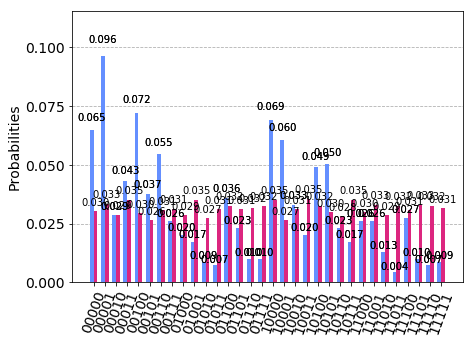

In [510]:
plot_histogram([tomo_qc_real00.data[('Z', 'Z', 'Z', 'Z', 'Z')],tomo_qc_sim0['00'].data[('Z', 'Z', 'Z', 'Z', 'Z')]])

In [473]:
rho_real_sf00= tomo_qc_real00.fit(method='lstsq')

In [501]:
np.linalg.norm(rho_real_sf00)

0.25378976495348143

In [500]:
F_qc_0=state_fidelity(rho_qc_sf0, rho_real_sf00)
print(F_qc_0)

0.04714642091918851


Fidelity between the real-quantum-computer-data reconstruction and the ideal statevector

In [475]:
F_qc_1=state_fidelity(reduced(psi_qc0,'00'), rho_real_sf00)
print(F_qc_1)

0.03647072403810532


In [489]:
test_allzero=np.zeros((32,32))
test_allzero[0][0]=1
F_qc_test=state_fidelity(reduced(psi_qc0, '00'),test_allzero)
print(F_qc_test)

0.03125000000000001


In [503]:
qctom_trans = transpile(qctom, backend=backend)

AttributeError: 'list' object has no attribute 'draw'

In [504]:
for qc_trans in qctom_trans:
    print(qc_trans.depth())

28
27
27
26
31
31
28
28
26
36
29
38
39
35
30
33
25
33
25
38
30
28
38
38
28
42
28
33
32
28
27
32
26
32
31
32
33
31
25
34
34
38
28
27
33
34
39
26
36
29
38
30
25
26
33
34
35
25
35
34
24
38
24
28
36
33
27
34
34
34
35
30
24
36
28
27
25
26
24
33
32
29
36
31
25
27
30
25
34
25
34
26
26
25
30
33
36
39
31
26
30
34
33
28
38
24
34
28
32
30
29
30
39
33
27
35
30
31
26
33
29
30
28
38
29
30
31
30
27
24
36
42
35
36
30
36
26
30
25
24
29
30
34
31
32
27
30
26
27
36
33
28
35
28
25
38
33
34
30
25
33
33
27
33
39
27
39
26
30
36
33
26
27
31
30
30
28
30
34
27
32
32
30
32
30
33
25
26
29
26
29
28
30
25
36
25
33
25
26
30
25
25
33
25
33
25
32
38
37
25
38
31
28
34
35
26
31
39
38
34
42
30
27
28
31
30
33
35
34
30
25
28
24
26
30
36
27
32
28
33
29
32
27
